<a href="https://colab.research.google.com/github/EdvardFoss/02456-deep-learning-with-PyTorch/blob/master/CADL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Forcasting Collision Risk for ESA Satellites by training a RNN on real-world CDMs

###02456 Deep Learning Project (Fall 2019)


By Edvard Foss (s191652)

##Acronyms

*   CDM: Conjunction Data Message
*   ESA: European Space Agency
*   LSTM: Long Short-Team Memory
*   RNN: Recurrent Neural Network




##Motivation

The Space Debris Crisis caused by the Kessler Syndrom is getting worse exponentially. As a space entusiast I would like to take part in developing ways of mitigating the effect and avoid furter buildup of debris in space. Avoiding orbital collisions would have a significant effect.

##Background

Objects in orbit larger than 10cm are tracked by the Space Surveillance Network and their position is released in the form of a globally shared catalogue.

In the context of this activity, the orbits of these satellites are propagated and when a close approach with any object in the catalogue is detected a Conjunction Data Message (CDM) is assembled and released. Each CDM contains multiple attributes about the approach.

For this project, due to Space Debris Office requirements, we are going to create a RNN that will, by inputting the the CDMs recorded up to 2 days prior to the closest approach, predict the final risk of collision.

##Milestones


1.   Pre-process data and make the data into a supervised learning problem
2.   Implement the LSTM
3.   Train and Test the network
4.   Optimize the network

if time: SigOpt




##Pre-Processing

###Mount Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


For this project we will be a regression problem where we would like to predict the `max_risk_estimate` for the last possible CDM from all data up until `time_to_tca`=2. We will therefor remove all the data we are not going to use. 

##Load Data

In [0]:
# load
from pandas import read_csv, Grouper
from matplotlib import pyplot
import numpy as np
# load dataset
data = read_csv('/content/drive/My Drive/DL/train_data.csv', usecols=[0,1,4]) #max 4
data.shape

(162634, 3)

##Split into time-series sequences & prepare for RNN

Now we will splitt into the sequences. By group and only use samples that include data for more than 2 days prior to the TCA.

In [0]:
group_sequences=data.groupby(['event_id'])

#delete all events that have less than 2 days of data
events=group_sequences.first()
events2=group_sequences.last()

threshold=int(2)#gives series of T/F if the sample/group starts its TCA LESS THAN 2 days before
events_tca_correct= events['time_to_tca'].apply(lambda x: x < threshold)
events2_tca_correct=events2['time_to_tca'].apply(lambda y: y > threshold)


#Groups we DO NOT WANT to keep
index_for_data_groups=list(events_tca_correct[events_tca_correct].index)
index_for_data_groups2=list(events2_tca_correct[events2_tca_correct].index)
indi=index_for_data_groups+index_for_data_groups2

#Remove all bad data
indi=np.sort(indi)

index_del=[]
#Get all indexes
for t in indi:
    index=list(group_sequences.get_group(t).index)
    index_del=index_del+index

data_new=data.drop(index_del)

#split into samples by event_id

samples=[]
#get index to what we want
group_seq=data_new.groupby(['event_id'])
group_samples=list(group_seq.groups.keys())

for i in group_samples:
    df_sample=group_seq.get_group(i)
    df_risk = df_sample['max_risk_estimate']
    sample= df_risk.values
    if len(sample)>6:
      samples.append(sample)
#8892 samples
samples=np.asarray(samples)

In [0]:
print('Number of samples for training: ' +str(len(samples)))

Number of samples for training: 7946


In [0]:
len(samples[40])

## Partitioning the dataset

To build our dataset, we need to create inputs and targets for each sequences and partition sentences it into training, validation and test sets. 80%, 10% and 10% is a common distribution. 

We can use PyTorch's `Dataset` class to build a simple dataset where we can easily retrieve (inputs, targets) pairs for each of our sequences.

In [0]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

    
def create_datasets(samples, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    # Define partition sizes
    num_train = int(len(samples)*p_train)
    num_val = int(len(samples)*p_val)
    num_test = int(len(samples)*p_test)

    # Split samples into partitions
    samples_train = samples[:num_train]
    samples_val = samples[num_train:num_train+num_val]
    samples_test = samples[-num_test:]

    def get_inputs_targets_from_samples(samples): 
        #criterion = nn.MSELoss()
        # Define empty lists
        inputs, targets, no_pre, loss = [], [], [],[]
        
        #inputs are what is left after that the 6 last values of the sample 
        #has been extracted to be the output
        for i in range(len(samples)):
            len_sample=len(samples[i])
            inputs.append(samples[i][:(len_sample-6)])
            no_pre.append(samples[i][-6:-5])
            targets.append(samples[i][-1:])
            #loss.append(criterion(torch.Tensor(no_pre),torch.Tensor(targets)))
        print(sum(loss)/len(samples))
        print(targets[0])
        print(no_pre[0])
        return inputs, targets

    # Get inputs and targets for each partition
    inputs_train, targets_train = get_inputs_targets_from_samples(samples_train)
    inputs_val, targets_val = get_inputs_targets_from_samples(samples_val)
    inputs_test, targets_test = get_inputs_targets_from_samples(samples_test)

    # Create datasets
    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_val, targets_val)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set
    

training_set, validation_set, test_set = create_datasets(samples, Dataset)

print(f'We have {len(training_set)} samples in the training set.')
print(f'We have {len(validation_set)} samples in the validation set.')
print(f'We have {len(test_set)} samples in the test set.')



###Zero-padding
We need to find the maximum input length such that we can zero-pad the inputs to the correct length.

In [0]:
length=1

for i in range(len(training_set)):
  new_length=len(training_set[i][0])
  if new_length>length:
    length=new_length
  else:
    length=length
print('Length of longest input sequence: ' + str(length))
  

Length of longest input sequence: 17


Zero-padding trail. Example of a zero-padded input sequence.

In [0]:
import torch.nn.functional as F
import torch
seq=training_set[0][0]
max_length=17
seq = torch.Tensor(seq)
length=len(seq)
dif=max_length-length
seq=F.pad(seq, pad=(0,dif),mode='constant', value=0)

print(seq)


Test: List of all sample lengths. Must be done with all inputs. 

#Introduction to LSTM

A vanilla RNN suffers from [the vanishing gradients problem](http://neuralnetworksanddeeplearning.com/chap5.html#the_vanishing_gradient_problem) which gives challenges in saving memory over longer sequences. To combat these issues the gated hidden units were created. The two most prominent gated hidden units are the Long Short-Term Memory (LSTM) cell and the Gated Recurrent Unit (GRU), both of which have shown increased performance in saving and reusing memory in later timesteps. In this exercise, we will focus on LSTM but you would easily be able to go ahead and implement the GRU as well based on the principles that you learn here.

LSTMs have also shown good results for sequences of unequal timesteps.

Below is a figure of the LSTM cell:

![lstm](https://i.imgur.com/3VkmUCe.png)
Source: https://arxiv.org/abs/1412.7828


The LSTM cell contains three gates, input, forget, output gates and a memory cell.
The output of the LSTM unit is computed with the following functions, where $\sigma = \mathrm{softmax}$.
We have input gate $i$, forget gate $f$, and output gate $o$ defines as

- $i = \sigma ( W^i [h_{t-1}, x_t])$

- $f = \sigma ( W^f [h_{t-1},x_t])$

- $o = \sigma ( W^o [h_{t-1},x_t])$

where $W^i, W^f, W^o$ are weight matrices applied to a concatenated $h_{t-1}$ (hidden state vector) and $x_t$ (input vector)  for each respective gate.

$h_{t-1}$, from the previous time step along with the current input $x_t$ are used to compute the a candidate $g$

- $g = \mathrm{tanh}( W^g [h_{t-1}, x_t])$

The value of the cell's memory, $c_t$, is updated as

- $c_t = c_{t-1} \circ f + g \circ i$

where $c_{t-1}$ is the previous memory, and $\circ$ refers to element-wise multiplication.

The output, $h_t$, is computed as

- $h_t = \mathrm{tanh}(c_t) \circ o$

and it is used for both the timestep's output and the next timestep, whereas $c_t$ is exclusively sent to the next timestep.
This makes $c_t$ a memory feature, and is not used directly to compute the output of the timestep.

#Implementing LSTM

The collision is a deterministic event and as such its probability after the TCA is either 1 or 0. The risk reported in the CDMs, and predicted here, is some kind of measure of the confidence we have on a collision happening. The number is used to decide on whether to perform an avoidance manouvre or not (note that such a decision may be wrong after all as the collision would never have happened anyway,there is basically no way to know). In this project we wish to create a model allowing to make that decision in advance, i.e. based only on the CDMs with TCA > 2 days. As a ground truth to know whether the Space Debris Office at ESA would decide to perform the manouvre or not, they use the take the risk of the latest available CDMs.

A lot of human factors and non-mathematical processes enter in this a set-up. This problem is therefor very suitable for a neural network. As the samples are sequences a RNN should be used. However,the vanilla RNN suffers from [the vanishing gradients problem as stated earlier. For this project we will implement our RNN model as a LSTM.

We are going to mask the inputs using the pad pack utility. The max_length will be put to 17 as that is the longest.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self, seq_len, input_dim, hidden_dim, layer_dim, output_dim):
        super(Net, self).__init__()

        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Sequence length
        self.seq_len = seq_len

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, dropout= 0.2)
        #dropout had a worsening effect

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # Initiate hidden layer
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))

        
    def forward(self, x, length_seq):
      #  print(x.size())
        
       pack = torch.nn.utils.rnn.pack_padded_sequence(x, lengths=(torch.LongTensor([length_seq]).cpu().numpy()), batch_first=True)

       #print('Before LSTM')
       #print(pack)

        # 17 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
       packed, (hn, cn) = self.lstm(x)

      # print('After LSTM')
       #print(packed)
       #print(packed.size())

       #out=torch.nn.utils.rnn.pad_packed_sequence(packed, total_length=17, batch_first=True)
       #print(out[0])
       # print('After unpack')
       # print(out)
       #out=out.reshape(1,17,1)        
        # Index hidden state of last time step
       out = self.fc(packed[:, -1, :]) 
       return out


In [0]:
pip install adabound

##Training Loop

In [0]:
import matplotlib.pyplot as plt
import adabound

# Model paramaters

output_dim = 1
input_dim =1
seq_len=17
max_length=17

# Hyper-parameters
num_epochs = 35
hidden_dim = 100 # 100. worse with 150
layer_dim = 2
l_r=0.001 #ADAM: Above 0.001, increasing the learning rate increased the time to train and also increased the variance in training time (as compared to a linear function of model size).

# Create network
net = Net(seq_len, input_dim, hidden_dim, layer_dim, output_dim)


# Define a loss function and optimizer for this problem
criterion = nn.MSELoss() #https://medium.com/data-science-group-iitr/loss-functions-and-optimization-algorithms-demystified-bb92daff331c 1)MSE
optimizer = adabound.AdaBound(net.parameters(), lr=0.0001, final_lr=0.001) #1) ADAM torch.optim.Adam(net.parameters(), lr=l_r)    # 2) 

# Track loss
training_loss, validation_loss = [], []

# Track accuracy
accuracy = []

# Track correct class
correct=int(0)

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    net.eval()
        
    # For each sample in validation set
    for inputs, targets in validation_set:
                
        # Convert input to tensor & zero-pad
        inputs = torch.FloatTensor(inputs)
        length=len(inputs)
        dif=max_length-length
        inputs=F.pad(inputs, pad=(0,dif),mode='constant', value=0)
        inputs=inputs.reshape(1,17,1)
        
        # Convert target to tensor
        targets = torch.FloatTensor(targets)       
        
        # Forward pass
        outputs = net.forward(inputs, length)

        # Compute loss
        loss = criterion(outputs, targets)

        #Compute accuracy
        accuracy.append(abs(outputs.item()-targets.item())/abs(targets.item()))

              
        # Update loss
        epoch_validation_loss += loss.detach().numpy()
    
    net.train()
    
    # For each sentence in training set
    for inputs, targets in training_set:
             
         # Convert input to tensor & zero-pad
        inputs = torch.FloatTensor(inputs)
        length=len(inputs)
        dif=max_length-length
        inputs=F.pad(inputs, pad=(0,dif),mode='constant', value=0)
        inputs=inputs.reshape(1,17,1)

        # Convert target to tensor
        targets = torch.FloatTensor(targets)
        
        # Forward pass
        outputs = net(inputs, length)

        # Compute loss
        loss = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update loss
        epoch_training_loss += loss.detach().numpy()
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss every 5 epochs
    if i % 5 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

        
# Get first sample in test set
inputs, targets = test_set[0]

# Convert input to tensor
inputs = torch.FloatTensor(inputs)
length=len(inputs)
dif=max_length-length
inputs=F.pad(inputs, pad=(0,dif),mode='constant', value=0)
inputs=inputs.reshape(1,17,1)
# Convert target to tensor
targets = torch.Tensor(targets)

# Forward pass
outputs = net.forward(inputs, length)

print('\nInput sequence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

print('\nPredicted sequence:')
print(outputs)

print('\nAccuracy:')
len_acc=len(accuracy)
sum_acc=sum(accuracy)
acc_tot=int((1-sum_acc/len_acc)*100)
print(str(acc_tot) + ' %')


1) AdaBound shows an improved accuracy of the model. 89% accuracy and MSE=0.38 (hYPER: 15epochs, 100 hidden dim lr: 0.0001) vs. Adam 88% MSE=0.39 (hYPER: 35epochs, 100 hidden dim lr: 0.001)

###Plot MSE Results

In [0]:
import matplotlib.pyplot as plt

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()



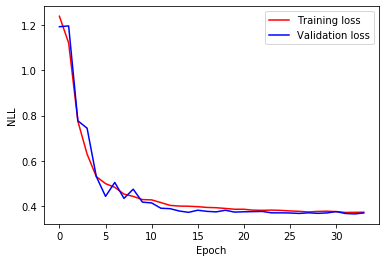

In [0]:
import matplotlib.pyplot as plt

plot_tl=training_loss[1:]
plot_vl=validation_loss[1:]
# Plot training and validation loss
epoch = np.arange(len(plot_tl))
plt.figure()
plt.plot(epoch, plot_tl, 'r', label='Training loss',)
plt.plot(epoch, plot_vl, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

#Testing & Classification Performance Results

We run through the whole test-set to statistically evaluate the results from the predictions of the final risk. Additionally we test the model on classifying the high and low risks as explained in the paper. 

In [0]:
tar=[]
pre=[]
esa=[]


for inputs, targets in test_set:

  # Convert input to tensor
  esain=inputs
  inputs = torch.FloatTensor(inputs)
  length=len(inputs)
  dif=max_length-length
  inputs=F.pad(inputs, pad=(0,dif),mode='constant', value=0)
  inputs=inputs.reshape(1,17,1)

  # Convert target to tensor
  targets = torch.Tensor(targets)

  # Forward pass
  outputs = net.forward(inputs, length)

  #Classify and calculate accuracy
  esa.append(esain[-1]>=-6)
  pre.append(outputs.item()>=-6)
  tar.append(targets.item()>=-6)

print('\nInput Risk Sequence:')
print(inputs)

print('\nTarget Risk:')
print(targets)
print('Target Risk in Percentage: ' + str(10**(targets.item()))+ ' %')

print('\nPredicted Final Risk:')
print(outputs)
print('Predicted Risk in Percentage: ' + str(10**(outputs.item()))+ ' %')



##Confusion matrix
Create a confusion matrix for the low and high classification of final risks.

##Confusion Matrix Stacked LSTM

In [0]:
from sklearn.metrics import confusion_matrix

confusion_matrix(tar, pre)

###Confusion Matrix ESA Model


In [0]:
confusion_matrix(tar,esa)

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

###Standardized Confusion Matrix (ESA model)

In [0]:
plot_confusion_matrix(tar, esa, classes=['Low Risk', 'High Risk'], normalize=False,cmap=plt.cm.Blues)

plt.show()

###Standardized Confusion Matrix (Stacked LSTM model)

In [0]:
plot_confusion_matrix(tar, pre, classes=['Low Risk', 'High Risk'], normalize=False,cmap=plt.cm.Blues)

plt.show()

#Masking w/ torch.nn.utils.rnn.pack_padded_sequence

###Summary of Shape Transformations

In [0]:
# (batch_size X max_seq_len X embedding_dim) --> Sort by seqlen ---> (batch_size X max_seq_len X embedding_dim)
# (batch_size X max_seq_len X embedding_dim) --->      Pack     ---> (batch_sum_seq_len X embedding_dim)
# (batch_sum_seq_len X embedding_dim)        --->      LSTM     ---> (batch_sum_seq_len X hidden_dim)
# (batch_sum_seq_len X hidden_dim)           --->    UnPack     ---> (batch_size X max_seq_len X hidden_dim)

###Masking example

In [0]:
import torch
from torch.autograd import Variable

# Get first sample in test set
inputs, targets = test_set[7]

# Convert input to tensor
inputs = torch.FloatTensor(inputs)
length=len(inputs)
dif=17-length
inputs=F.pad(inputs, pad=(0,dif),mode='constant', value=0)
inputs=inputs.reshape(1,17,1)
seq_in = Variable(inputs)
seq_length = [length]
pack = torch.nn.utils.rnn.pack_padded_sequence(seq_in, seq_length, batch_first=True)
print (pack)

unpack=torch.nn.utils.rnn.pad_packed_sequence(pack, total_length=17, batch_first=True)
print(unpack)

